# Central Arizona (Phoenix) Watershed

In [1]:
watershed = 'CentralArizona'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-50,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1. Discharge

In [4]:
# streamflow data
data = pd.read_csv('http://data.gios.asu.edu/datasets/cap/266_mean_discharge_1.csv',
                        header = 0,index_col = 'ObsDate',parse_dates = True, infer_datetime_format = True)
data.head()

SiteName  DataValue  QualifierID
ObsDate                                                                  
1960-10-01  Sycamore Creek Near Fort Mcdowwell,AZ          0            1
1960-10-02  Sycamore Creek Near Fort Mcdowwell,AZ          0            1
1960-10-03  Sycamore Creek Near Fort Mcdowwell,AZ          0            1
1960-10-04  Sycamore Creek Near Fort Mcdowwell,AZ          0            1
1960-10-05  Sycamore Creek Near Fort Mcdowwell,AZ          0            1

In [5]:
data.tail()

SiteName  DataValue  QualifierID
ObsDate                                                                  
2008-03-17  Sycamore Creek Near Fort Mcdowwell,AZ          6            2
2008-03-18  Sycamore Creek Near Fort Mcdowwell,AZ          6            2
2008-03-19  Sycamore Creek Near Fort Mcdowwell,AZ          6            2
2008-03-20  Sycamore Creek Near Fort Mcdowwell,AZ          5            2
2008-03-21  Sycamore Creek Near Fort Mcdowwell,AZ          4            2

SCNFM_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

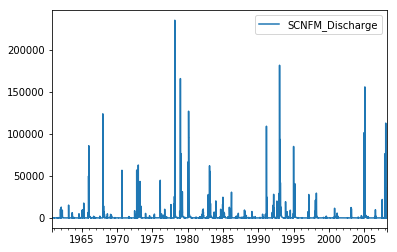

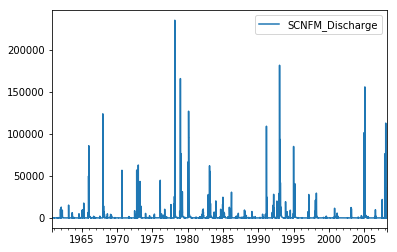

In [9]:
prep = copy.deepcopy(data[['DataValue']]) # Variable name
prep.columns =['SCNFM_Discharge']
prep = threC(prep,'Discharge')

# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*28.3168  # convert to the right unit(m3/s to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### Hydrometeorology

### 2. Precipitation

In [18]:
data = pd.read_csv('http://data.gios.asu.edu/datasets/cap/266_precipitation_1.csv',
                    header = 0,index_col = 'ObsDate' ,parse_dates = True, infer_datetime_format = True)
data.head(5)

SiteName  DataValue  QualifierID
ObsDate                                         
1948-07-01  Bartlett Dam          0          NaN
1948-07-02  Bartlett Dam          0          NaN
1948-07-03  Bartlett Dam          0          NaN
1948-07-04  Bartlett Dam          0          NaN
1948-07-05  Bartlett Dam          0          NaN

In [19]:
data['SiteName'].unique()

array(['Bartlett Dam', 'Fountain Hills', 'Mormon Flat', 'Punkin Ctr',
       'Stewart Mtn', 'Sunflower 3 NNW  '], dtype=object)

BartlettDam_Precipitation
ObsDate                              
1948-07-01                        0.0
1948-07-02                        0.0

(21701, 1)
1948-07-01 00:00:00 2008-02-29 00:00:00


FountainHills_Precipitation
ObsDate                                
1979-10-01                          0.0
1979-10-02                          0.0

(10045, 1)
1979-10-01 00:00:00 2008-02-29 00:00:00


MormonFlat_Precipitation
ObsDate                             
1923-08-01                       NaN
1923-08-02                       0.0

(29374, 1)
1923-08-01 00:00:00 2008-02-29 00:00:00


PunkinCtr_Precipitation
ObsDate                            
1915-11-01                      NaN
1915-11-02                      NaN

(31038, 1)
1915-11-01 00:00:00 2008-02-29 00:00:00


StewartMtn_Precipitation
ObsDate                             
1948-07-01                       6.0
1948-07-02                       0.0

(21731, 1)
1948-07-01 00:00:00 2008-02-29 00:00:00


Sunflower3NNW_Precipitation
ObsDate                                
1916-11-01                          0.0
1916-11-02                          0.0

(13050, 1)
1916-11-01 00:00:00 1984-11-30 00:00:00
The final table is:


BartlettDam_Precipitation FountainHills_Precipitation  \
1915-11-01                       NaN                         NaN   
1915-11-02                       NaN                         NaN   

           MormonFlat_Precipitation PunkinCtr_Precipitation  \
1915-11-01                      NaN                     NaN   
1915-11-02                      NaN                     NaN   

           StewartMtn_Precipitation Sunflower3NNW_Precipitation  
1915-11-01                      NaN                         NaN  
1915-11-02                      NaN                         NaN

BartlettDam_Precipitation FountainHills_Precipitation  \
2008-02-28                         0                           0   
2008-02-29                         0                           0   

           MormonFlat_Precipitation PunkinCtr_Precipitation  \
2008-02-28                        0                       0   
2008-02-29                        0                       0   

           StewartMtn_Precipitation Sunflower3NNW_Precipitation  
2008-02-28                        0                         NaN  
2008-02-29                        0                         NaN

BartlettDam_Precipitation FountainHills_Precipitation  \
1915-11-01                       NaN                         NaN   
1915-11-02                       NaN                         NaN   
1915-11-03                       NaN                         NaN   
1915-11-04                       NaN                         NaN   
1915-11-05                       NaN                         NaN   

           MormonFlat_Precipitation PunkinCtr_Precipitation  \
1915-11-01                      NaN                     NaN   
1915-11-02                      NaN                     NaN   
1915-11-03                      NaN                     NaN   
1915-11-04                      NaN                     NaN   
1915-11-05                      NaN                     NaN   

           StewartMtn_Precipitation Sunflower3NNW_Precipitation  
1915-11-01                      NaN                         NaN  
1915-11-02                      NaN                         NaN  
1915-11-03                      NaN                         NaN  
1915-11-04                      NaN                         NaN  
1915-11-05                      NaN                         NaN

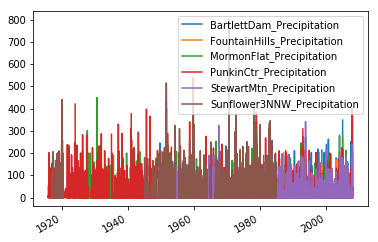

In [22]:
df_lst = []
for site in data['SiteName'].unique():
    df=data[data['SiteName']==site]
    df=pd.DataFrame(pd.to_numeric(df['DataValue'], errors='coerce'))
    df.columns=[site.replace(' ','')+'_Precipitation']
    df=threC(df,'Precipitation') 
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
    df_lst.append(df)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "sum") 
display(prep.head())
prep.plot()

BartlettDam_Precipitation
FountainHills_Precipitation
MormonFlat_Precipitation
PunkinCtr_Precipitation
StewartMtn_Precipitation
Sunflower3NNW_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

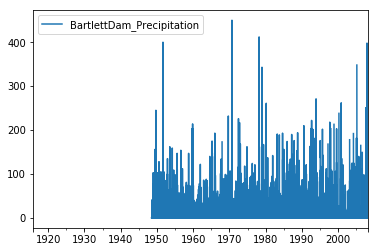

<Figure size 432x288 with 0 Axes>

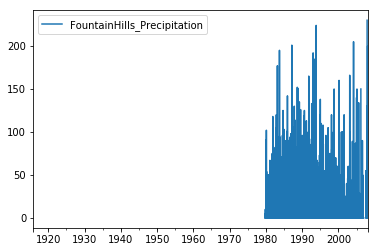

<Figure size 432x288 with 0 Axes>

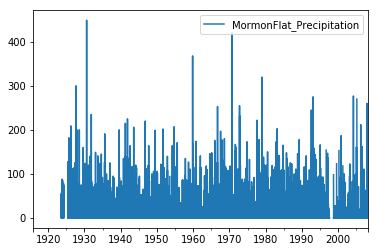

<Figure size 432x288 with 0 Axes>

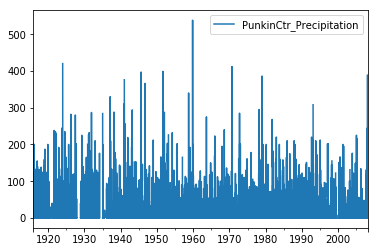

<Figure size 432x288 with 0 Axes>

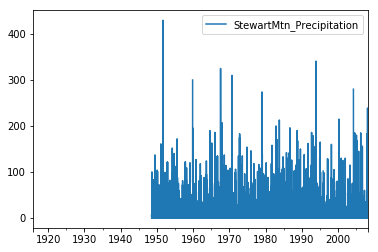

<Figure size 432x288 with 0 Axes>

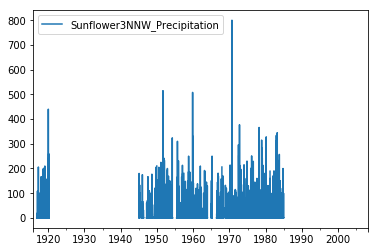

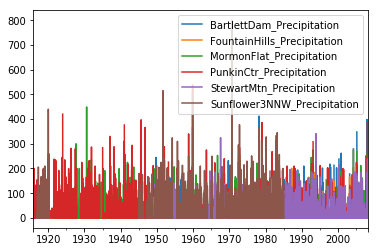

In [23]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

In [24]:
# Put all the tables to the same date format
# data_soil.index= pd.to_datetime(data_soil.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data.index= pd.to_datetime(data.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data_lwr.index= pd.to_datetime(data_lwr.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S

# Bring them together
result1 = pd.concat([Discharge,Precipitation], axis=1,
                    join='outer')


In [25]:
result1.index.rename('DateTime', inplace = True)
result1.head(5)

SCNFM_Discharge  BartlettDam_Precipitation  \
DateTime                                                 
1915-11-01              NaN                        0.0   
1915-11-02              NaN                        NaN   
1915-11-03              NaN                        NaN   
1915-11-04              NaN                        NaN   
1915-11-05              NaN                        NaN   

            FountainHills_Precipitation  MormonFlat_Precipitation  \
DateTime                                                            
1915-11-01                          NaN                       0.0   
1915-11-02                          NaN                       NaN   
1915-11-03                          NaN                       NaN   
1915-11-04                          NaN                       NaN   
1915-11-05                          NaN                       NaN   

            PunkinCtr_Precipitation  StewartMtn_Precipitation  \
DateTime                                                        
1915-11-01                      0.0                       0.0   
1915-11-02                      NaN                       NaN   
1915-11-03                      NaN                       NaN   
1915-11-04                      NaN                       NaN   
1915-11-05                      NaN                       NaN   

            Sunflower3NNW_Precipitation  
DateTime                                 
1915-11-01                          0.0  
1915-11-02                          NaN  
1915-11-03                          NaN  
1915-11-04                          NaN  
1915-11-05                          NaN

In [26]:
# Write data to csv for further inspection
result1.to_csv('1_'+watershed+'_Download_Aggregation_Daily.csv', sep=',')

In [27]:
# Compare Length of each non-NAN data for each variable.